# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи


<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

> Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. Однако [The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)  создал набор данных, содержащий фактические транзакции за 2010 и 2011 годы. С ним нам как раз и предлагается поработать в этом кейсе. 

> В нашем распоряжении будет набор данных, который содержит все транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных о транзакциях.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках каждого из уникальных клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.




## Данные и их описание

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



Импорт необходимых библиотек:

In [538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings 
import nbformat

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

# импортируем метрику силуэт
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.pipeline import Pipeline

## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомьтесь с исходными данными поближе:

* Проведите статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнайте, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнайте, из каких стран совершались транзакции.
* Исследуйте данные на наличие пропусков и дубликатов.
* Переведите столбцы в корректные форматы (например, даты в формат datetime).

In [539]:
data = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Переведем данные столбца InvoiceDate в формат datetime и посмотрим на диапазон дат в , за которые были совершены транзакции.

In [540]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


Посмотрим на основные статистические данные пока по имеющимся признакам.

In [541]:
data.describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


Видим, что в количестве и цене товаров есть отрицательные значения, предполагаем, что это возвраты. По цене и количеству еще можно сказать, что есть оптовики, которые покупают много и на большие суммы. А также видим диапазон дат.

In [542]:
print('Number of unique customers: {}'.format(data['CustomerID'].unique().shape[0]))

Number of unique customers: 4373


In [543]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


Узнаем из каких стран совершались покупки:

In [544]:
country_array = data['Country'].unique()
print(country_array)
len(country_array)

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


38

## 2. Преобразование, очистка и анализ данных

### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалите их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [545]:
print(data.isnull().sum())
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


CustomerID     24.926694
Description     0.268311
dtype: float64

Визуализируем пропуски, чтобы было понятно, взаимосвязаны они или нет:

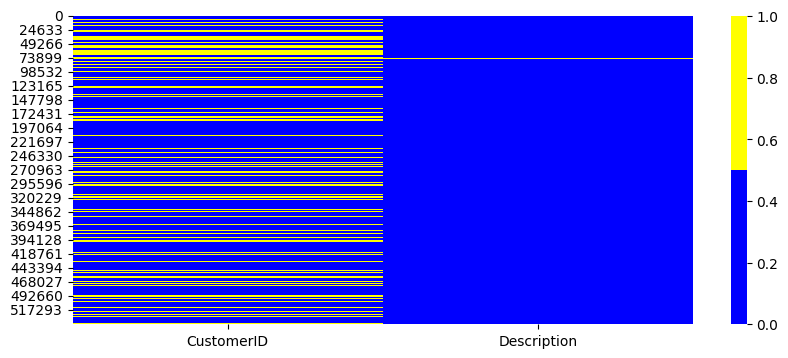

In [546]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

Видно,что пропуски в признаке Description в тех же же строках, где пропуски в CustomerID. Это значит, что пропуски взаимосвязаны.


In [547]:
data = data.dropna(subset=['CustomerID']) #удаляем пропуски в столбце CustomerID и вместе с ними удалятся пропуски в столбце Description

#### 2.1.2. Дубликаты

Проверим данные на наличие дубликатов. Удалим их из данных.


In [548]:
print(data.duplicated().sum())
data.drop_duplicates(inplace=True) #присвоим переменной data данные без дубликатов
data.info()

5225
<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  object        
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.6+ MB


In [549]:
data['CustomerID'] = data['CustomerID'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  int64         
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.6+ MB


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [550]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создайте в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента мы подготовили для вас функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). При желании вы можете самостоятельно модифицировать функцию для предобработки, чтобы учесть этот пограничный случай.

*Осторожно! Поиск отменённых транзакций занимает много времени из-за большого количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от мощности компьютера.*

In [551]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

*Осторожно! Поиск отмененных транзакций занимает достаточно длительное время из-за количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от компьютера.*

Узнайте, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалите их из данных.

Когда вы разобрались с возвратами, удалите транзакции с отрицательным количеством товара — они нам больше не нужны.



In [552]:
data['QuantityCanceled'].isna().sum() #узнаем сколько транзакций не имеют контрагентов
data = data.dropna(subset=['QuantityCanceled']) #удаляем транзакции без контрагентов
data = data[data['Quantity'] > 0] #удаляем транзакции с отрицательным количеством товара
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         392732 non-null  object        
 1   StockCode         392732 non-null  object        
 2   Description       392732 non-null  object        
 3   Quantity          392732 non-null  int64         
 4   InvoiceDate       392732 non-null  datetime64[ns]
 5   UnitPrice         392732 non-null  float64       
 6   CustomerID        392732 non-null  int64         
 7   Country           392732 non-null  object        
 8   QuantityCanceled  392732 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB


#### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

**Подсказка.** В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'.

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

In [553]:
import re
pattern = r'^[a-zA-Z]+'
#ищем значения в столбце StockCode, которые начинаются с латинских букв
special_stock_codes = data['StockCode'].apply(lambda x: bool(re.match(pattern, x)))
print(data[special_stock_codes])
data = data[~special_stock_codes] #удаляем строки с специальными транзакциями

       InvoiceNo StockCode Description  Quantity         InvoiceDate  \
45        536370      POST     POSTAGE         3 2010-12-01 08:45:00   
386       536403      POST     POSTAGE         1 2010-12-01 11:27:00   
1123      536527      POST     POSTAGE         1 2010-12-01 13:04:00   
1423      536540        C2    CARRIAGE         1 2010-12-01 14:05:00   
2239      536569         M      Manual         1 2010-12-01 15:35:00   
...          ...       ...         ...       ...                 ...   
541198    581493      POST     POSTAGE         1 2011-12-09 10:10:00   
541216    581494      POST     POSTAGE         2 2011-12-09 10:13:00   
541730    581570      POST     POSTAGE         1 2011-12-09 11:59:00   
541767    581574      POST     POSTAGE         2 2011-12-09 12:09:00   
541768    581578      POST     POSTAGE         3 2011-12-09 12:16:00   

        UnitPrice  CustomerID         Country  QuantityCanceled  
45          18.00       12583          France               0.0  
386

#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [554]:
display(data.describe())

data = data[data['UnitPrice'] > 0]
data.info()

,Quantity,InvoiceDate,UnitPrice,CustomerID,QuantityCanceled
count,391183.000000,391183,391183.000000,391183.000000,391183.000000
mean,13.179665,2011-07-10 19:37:28.017628416,2.874130,15295.083503,0.626569
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000,0.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13969.000000,0.000000
50%,6.000000,2011-07-31 12:05:00,1.950000,15158.000000,0.000000
75%,12.000000,2011-10-20 12:57:00,3.750000,16794.000000,0.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000,80995.000000
std,181.907403,NaN,4.284639,1710.359579,175.902239


<class 'pandas.core.frame.DataFrame'>
Index: 391150 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         391150 non-null  object        
 1   StockCode         391150 non-null  object        
 2   Description       391150 non-null  object        
 3   Quantity          391150 non-null  int64         
 4   InvoiceDate       391150 non-null  datetime64[ns]
 5   UnitPrice         391150 non-null  float64       
 6   CustomerID        391150 non-null  int64         
 7   Country           391150 non-null  object        
 8   QuantityCanceled  391150 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 29.8+ MB


#### 2.1.6. Общая стоимость товаров в транзакции

Добавьте в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

In [555]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34


Помимо рекомендованных преобразований, вы также можете придумать собственные и применить их к исходным данным.
После завершения предобработки сохраните результат очищения данных в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.


In [556]:
data_cleaned = data.copy()
data_cleaned.to_csv('data_cleaned.csv', index=False)

### 2.2. Разведывательный анализ

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



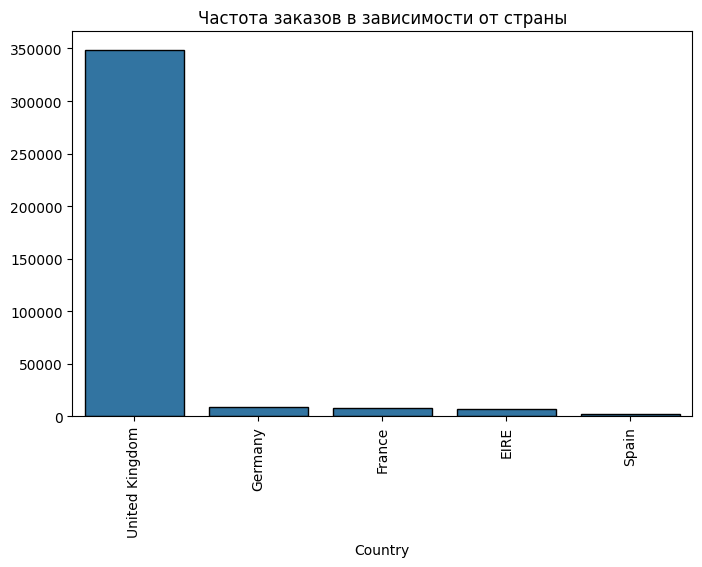

In [557]:
#сгруппируем данные по странам и посчитаем количество заказов в каждой из них
grouped_freq = data.groupby('Country')['InvoiceDate'].count().sort_values(ascending=False).head(5)
fig, ax = plt.subplots(figsize=(8, 5))
barplot_freq = sns.barplot(x = grouped_freq.index, y = grouped_freq.values, ax=ax)
barplot_freq.set_title('Частота заказов в зависимости от страны');
plt.xticks(rotation=90)
plt.show()

Видно, что чаще всего заказы совершаются в Великобритании. Далее идут Германия и Франция. Остальные страны имеют значительно меньшее количество заказов

Country
United Kingdom    6797691.44
Netherlands        283443.54
EIRE               247074.57
Germany            201520.71
France             181529.63
Name: TotalPrice, dtype: float64


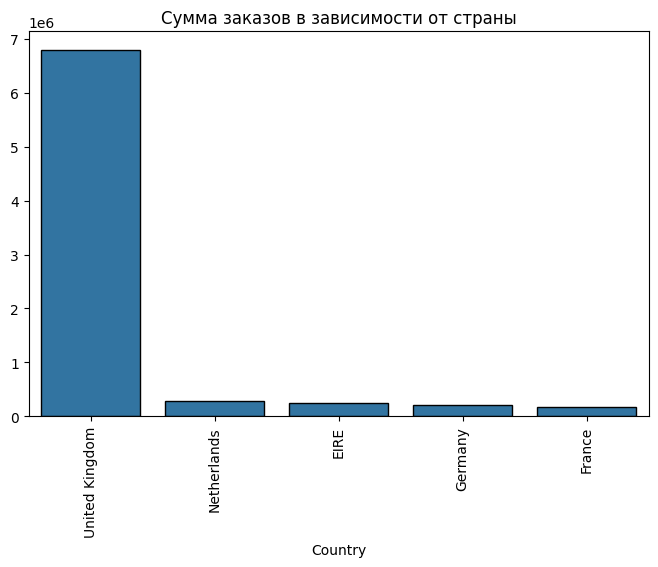

In [558]:
#сгруппируем данные по странам, но теперь посмотрим, какие страны приносят наибольшую выручку
grouped = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5)
print(grouped)
fig, ax = plt.subplots(figsize=(8, 5))
barplot = sns.barplot(x = grouped.index, y = grouped.values, ax=ax)
barplot.set_title('Сумма заказов в зависимости от страны');
plt.xticks(rotation=90)
plt.show()

А вот по сумме заказов картина немного другая - вслед за безусловным лидером Великобританией идут Нидерданды и Ирландия.

Month
1      453560.68
2      436043.09
3      571941.01
4      447922.86
5      647403.81
6      601238.45
7      581019.35
8      614704.38
9      928554.44
10     967436.46
11    1119641.60
12     894126.86
Name: TotalPrice, dtype: float64


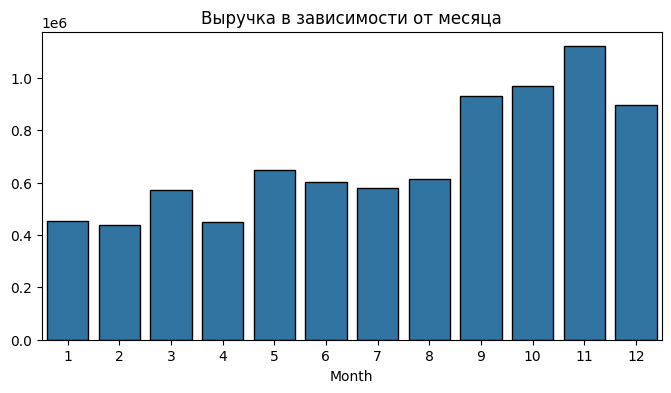

In [559]:
#Посмотрим на выручку в зависимости от месяца
data_copy = data.copy()
data_copy['Month'] = data_copy['InvoiceDate'].dt.month
grouped_month  = data_copy.groupby('Month')['TotalPrice'].sum()
print(grouped_month)
fig, ax = plt.subplots(figsize=(8, 4))
barplot = sns.barplot(x = grouped_month.index, y = grouped_month.values, ax=ax)
barplot.set_title('Выручка в зависимости от месяца');
plt.show()

Судя по графику, в продажах имеется сезонность - наибольший доход в ноябре, что вполне отражает действительость, так как идет подготовка к сезону подарков к Рождеству или освоение бюджета к концу года. Самые низкие продажи - в феврале и апреле.

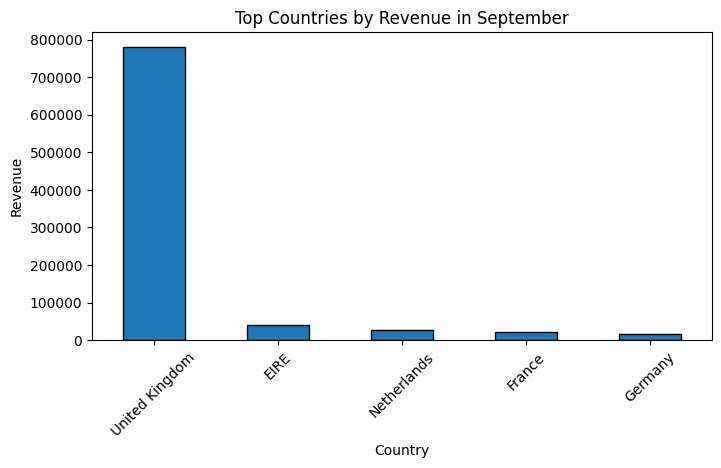

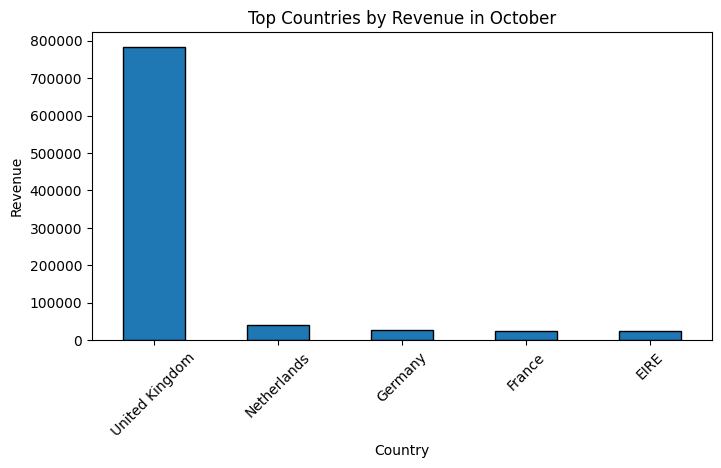

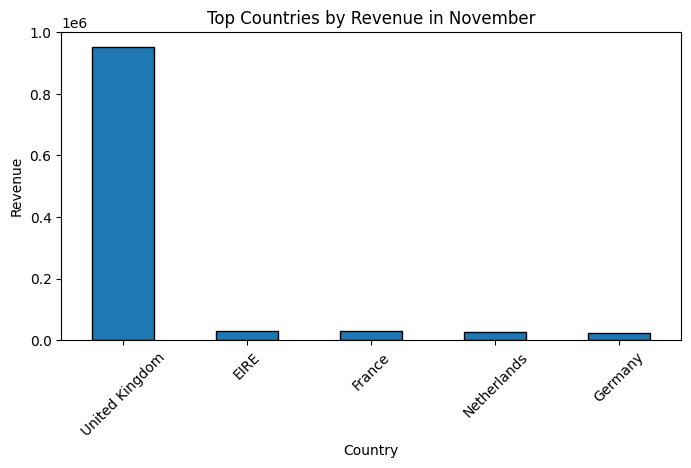

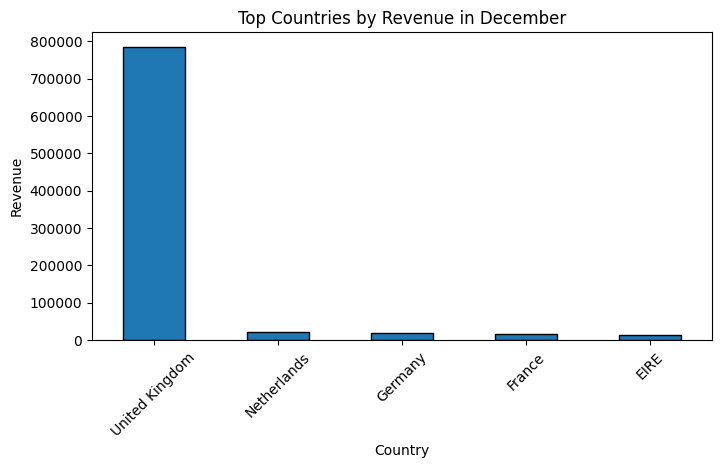

In [560]:
#Посмотрим, какие из стран приносят наибольшую сезонную выручку
months = [9, 10, 11, 12]
month_names = {9: 'September', 10: 'October', 11: 'November', 12: 'December'}

for month in months:
    month_data = data_copy[data_copy['Month'] == month]
    revenue_by_country = month_data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
    top_countries = revenue_by_country.head(5)

    plt.figure(figsize=(8, 4))
    top_countries.plot(kind='bar')
    plt.title(f'Top Countries by Revenue in {month_names[month]}')
    plt.xlabel('Country')
    plt.ylabel('Revenue')   
    plt.xticks(rotation=45)
    plt.show()


Видно, что в рейтинге стран, приносящих наибольшую выручку в пиковый сезон участвуют одни и те же страны, но в зависимотси от месяца они перемещаются в рейтинге. В сентябре и ноябре на втором месте после Великобритании Ирландия, а в октябре и декабре Нидерланды.

Hour
6       1.000000
7      16.304348
8      42.274510
9      86.456349
10    123.953795
11    158.582237
12    231.855738
13    207.947020
14    176.252492
15    148.222591
16     89.492424
17     70.475410
18     61.361702
19     65.897959
20     55.500000
dtype: float64


<Axes: title={'center': 'Количество заказов по часам'}, xlabel='Hour'>

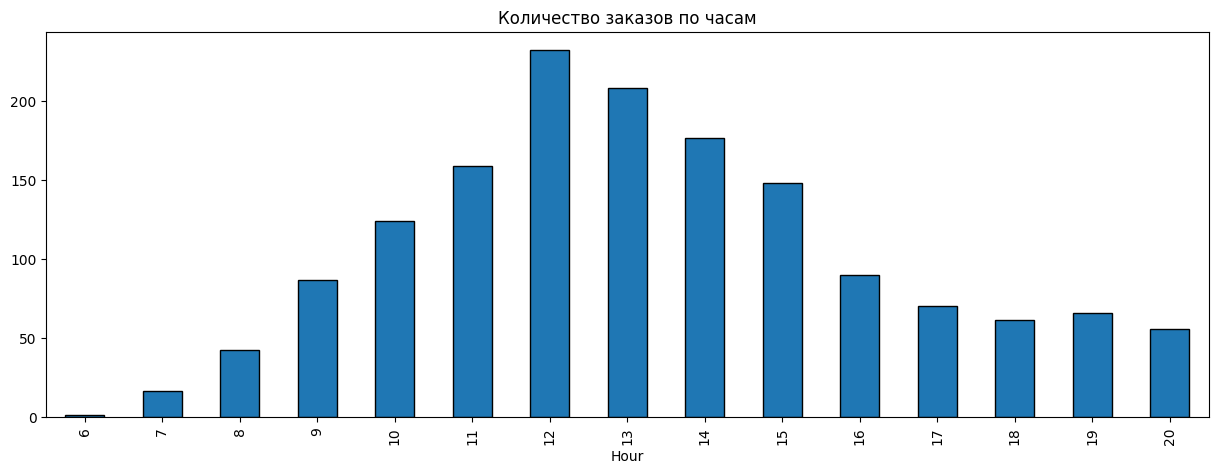

In [561]:
#Посмотрим на количество заказов в зависимости от времени суток по часам
data_copy['Date'] = data_copy['InvoiceDate'].dt.date
data_copy['Hour'] = data_copy['InvoiceDate'].dt.hour
grouped_mean_hour = data_copy.groupby(['Date','Hour'])['InvoiceDate'].count().unstack().mean()
print(grouped_mean_hour)
grouped_mean_hour.plot(kind='bar', figsize=(15, 5), title='Количество заказов по часам')


Судя по графику, наибольшее количество заказов поступает с 10:00 до 15:00. Пиковый час 12:00, где в среднем 232 заказа.

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. 

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [562]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34


In [563]:
#В качестве точки отсчёта $t_0$ берём дату на один день «младше», чем все наши данные.
# Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').
t0 = pd.to_datetime('2011-12-10 00:00:00') 
#Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни
rfm_table = pd.DataFrame()
rfm_table['Recency'] = (t0 - data.groupby("CustomerID")['InvoiceDate'].max()).dt.days
#Frequency для i-го клиента рассчитывается как количество уникальных заказов, сделанных i-ым клиентом.
rfm_table['Frequency'] = data.groupby('CustomerID')['InvoiceNo'].nunique()
#Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов)
rfm_table['Monetary'] = data.groupby('CustomerID')['TotalPrice'].sum()

In [564]:
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


После того как вы подготовите RFM-таблицу, визуализируйте каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot). Вы получите примерно следующие результаты (графики могут отличаться в зависимости от того, как вы выполните предобработку данных):

In [565]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [566]:
#находим 0.95 квантиль для Frequency и Monetary
threshold_frequency = rfm_table['Frequency'].quantile(0.95)
threshold_monetary = rfm_table['Monetary'].quantile(0.95)
#удаляем строки, в которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов
rfm_table = rfm_table[(rfm_table['Frequency'] <= threshold_frequency) & (rfm_table['Monetary'] <= threshold_monetary)]

Посмотрим, как теперь выглядят наши диаграммы по признакам:

In [567]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

Коробочки у Frequancy и Monetary расширились и графики перестали быть "перекошены" в сторону выбросов и стали более наглядно отражать статистику в данных.

## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

Чтобы результаты кластеризации было удобнее интерпретировать, вы можете уменьшить размерность исходных признаков до двух компонент.

**Подсказка.** Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать. Для удобства оберните эти шаги по предобработке данных в pipeline.

Произведите предобработку исходных данных. На основе RFM-признаков кластеризуйте клиентов онлайн-магазина подарков с помощью известных вам методов (используйте минимум три метода).

Подберите оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга). 

Выберите алгоритм с наибольшим коэффициентом силуэта, сделайте предсказание меток кластеров.


### Визуализируем наши данные

Text(0.5, 0, 'Monetary')

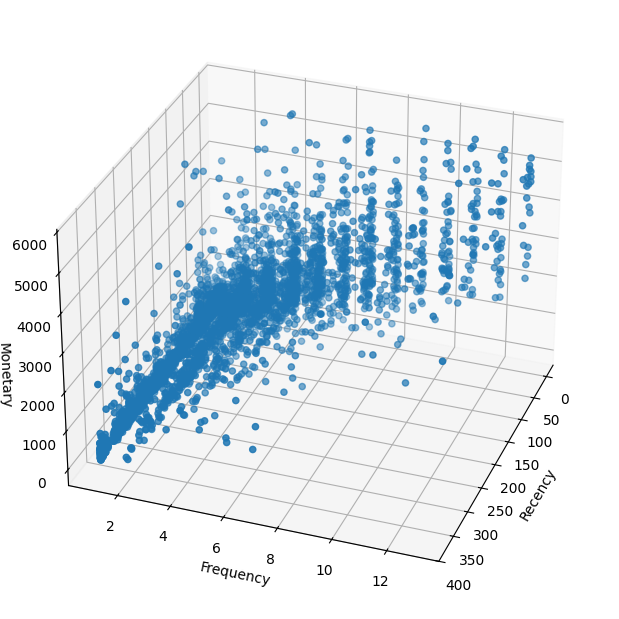

In [568]:
#созадим трехмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
#добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev =30
ax.scatter(rfm_table['Recency'].to_list(), rfm_table['Frequency'].to_list(), rfm_table['Monetary'].to_list())
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

Видим, что данные плохо разделяются в пространстве и шума достаточно много. Преобразуем их с помощью понижения размерности сначала с помощью PCA:

In [569]:
rfm_table_copy = rfm_table.copy()

In [570]:
pipeline_preprocessing = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))])
rfm_pca = pipeline_preprocessing.fit_transform(rfm_table_copy)
print(rfm_pca)

[[-2.13520066  1.40159569]
 [ 3.44712453  0.85287213]
 [ 0.62910337  0.08321704]
 ...
 [-1.42102558  0.16834651]
 [-0.31933001 -1.19828491]
 [ 0.77186997 -0.15752725]]


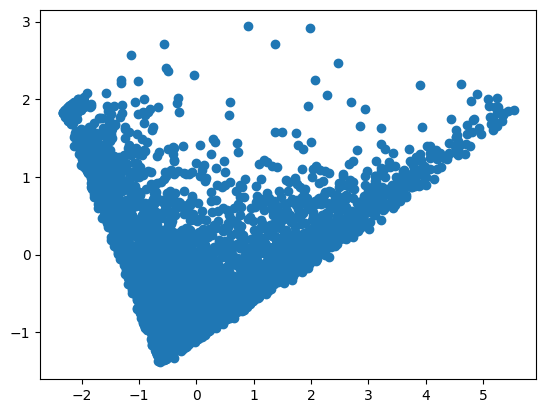

In [571]:
#посмотрим на данные после понижения размерности:
plt.scatter(rfm_pca[:,0], rfm_pca[:,1])

Видно, что от шумов,в целом, нам не удалось избавиться и данные в пространстве также очень плохо разделены. Попробуем алгоритм t-SNE:

In [572]:
pipeline_preprocessing_new = Pipeline([
    ('scaler', StandardScaler()),
    ('tsne', TSNE(n_components=2,perplexity=50, learning_rate=500,n_iter=5000,random_state=100))]) #возьмем оптимальное значение perplexity=50,
#так как у нас достаточное кол-во объектов в выборке.
rfm_tsne = pipeline_preprocessing_new.fit_transform(rfm_table)
print(rfm_tsne)

[[-18.226166  35.994556]
 [ 29.74723   46.65285 ]
 [ 51.972454   7.626572]
 ...
 [-61.92826   12.780834]
 [-16.591383 -56.721764]
 [ 40.572674 -11.29031 ]]


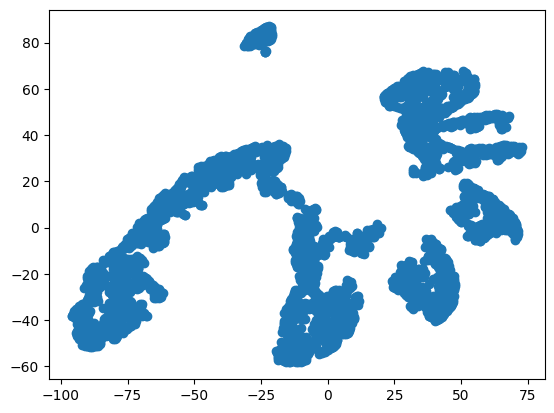

In [573]:
#посмотрим на данные после понижения размерности с помощью t-SNE:
plt.scatter(rfm_tsne[:,0], rfm_tsne[:,1])

Здесь уже в пространстве можно выделить кластеры.

## KMeans

Функция для подсчета коэффициента силуэта для KMeans:

In [574]:
def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.labels_)
    return silhouette

Используем для кластеризации алгоритм KMeans. Подберем оптимальное кол-во кластеров с помощью коэффициента силуэта:

<Axes: xlabel='cluster', ylabel='silhouette'>

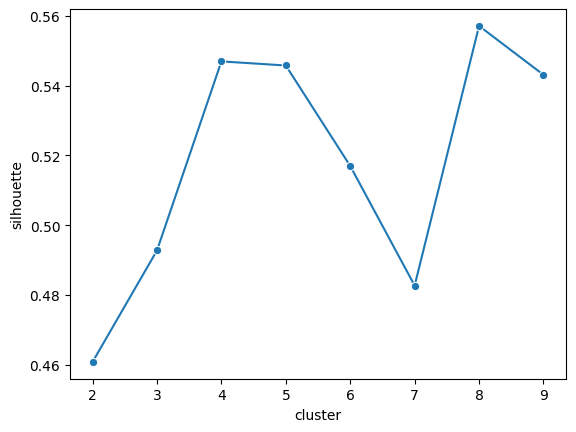

In [575]:
# создадим пустой словарь, ключами будут силуэт и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_tsne))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")   

Судя по графику, наибольшее значение коэффициента силуэта достигается при количестве кластеров равном 6, но для лучшей интерпретации для бизнес-задачи мы сделаем кластеризацию для 7 кластеров, тем более, что результат значения силуэта для 7-ми кластеров не сильно отличается.

In [576]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(rfm_tsne)
rfm_table['Kmeans_cluster'] = kmeans.labels_
rfm_table.Kmeans_cluster.value_counts()

Kmeans_cluster
4    812
2    808
3    719
6    487
1    481
0    373
5    364
Name: count, dtype: int64

Посмотрим на 3d-визуализацию наших кластеров.

<Axes: xlabel='x', ylabel='y'>

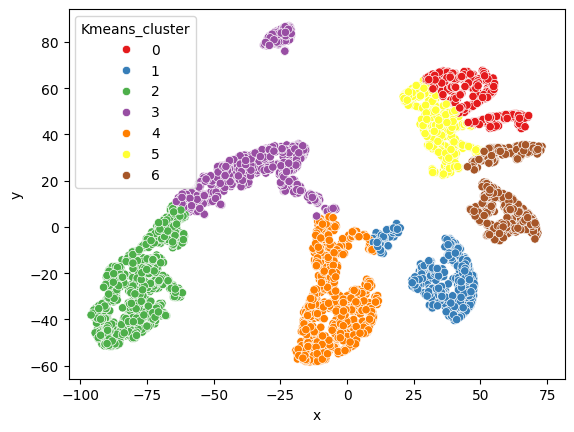

In [577]:
# визуализируем кластеризацию:
fig = plt.Figure(figsize=(12, 5))
rfm_tsne_df = pd.DataFrame(rfm_tsne, columns=['x', 'y'])
rfm_tsne_df['Kmeans_cluster'] = kmeans.labels_
sns.scatterplot(data=rfm_tsne_df, hue='Kmeans_cluster', x='x', y='y', palette='Set1')

На графике видно, что кластеризация, в целом, достаточно хорошая. Посморим на кластеры уже в нашей RFM-таблице в виде 3D.

In [578]:
#строим график
fig = px.scatter_3d(
    data_frame=rfm_table, #датафрейм 
    x = 'Recency', #ось абсцисс
    y = 'Frequency', #ось ординат
    z = 'Monetary', #ось аппликат
    color='Kmeans_cluster', #расцветка в зависимости от кластера
    log_x=True, 
    log_y=True,
    width=1000,
    height=700
)

#отображаем его
fig.show()
fig.write_html("data/scatter_3d_Kmeans_clusters.html")

Видим, что один из кластеров (клиенты, которые оформляли заказы недавно и по сумме выше среднего) в два-три раза больше, чем остальные. Возможно, имеет смысл добавить ещё один кластер.

In [579]:
from sklearn.metrics import davies_bouldin_score
davies = davies_bouldin_score(rfm_tsne,kmeans.labels_)
davies

np.float64(0.8046233567417512)

Так как наши данные с достаточно большой разницей в плотности, то алгоритм DBSCAN не подойдет.

## Agglomerative clustering

Функция для подсчета коэффициента силуэта для Agglomerative Clustering:

In [580]:
def get_agglosilhouette(cluster_num, X):
    agglo_clust =  AgglomerativeClustering(n_clusters=cluster_num)
    agglo_clust.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, agglo_clust.labels_)
    return silhouette

<Axes: xlabel='cluster', ylabel='silhouette'>

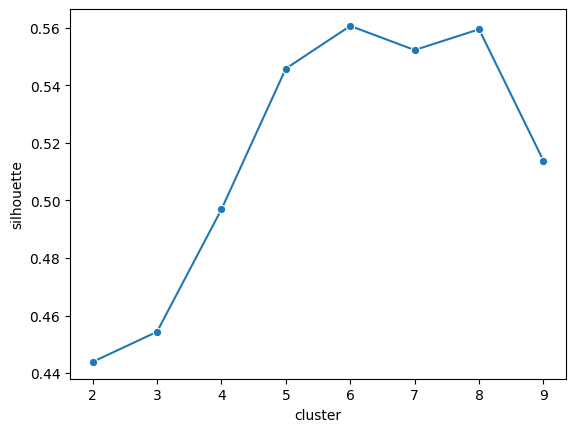

In [581]:
# создадим пустой словарь, ключами будут силуэт и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_agglosilhouette(cluster_num, rfm_tsne))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")  

Судя по графику, рекомендуется также разбивка на 5 кластера. Посмотрим как их сформирует этот алгоритм:

In [582]:
agglo_clust = AgglomerativeClustering(n_clusters=7,linkage='ward')
agglo_clust.fit(rfm_tsne)
rfm_table['Agglo_cluster'] = agglo_clust.labels_
rfm_table.Agglo_cluster.value_counts()

Agglo_cluster
2    901
1    782
0    737
4    613
3    593
6    304
5    114
Name: count, dtype: int64

<Axes: xlabel='x', ylabel='y'>

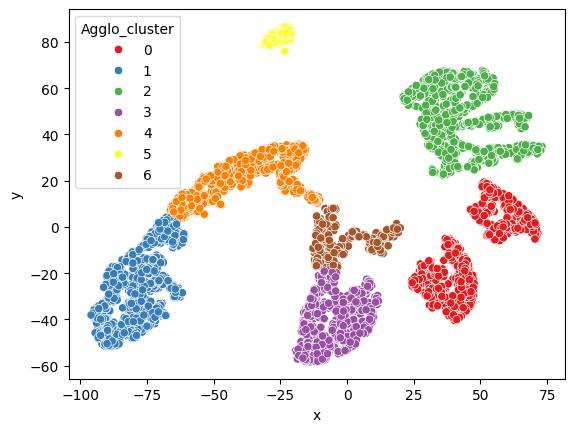

In [583]:
# визуализируем кластеризацию:
fig = plt.Figure(figsize=(15, 8))
rfm_tsne_df['Agglo_cluster'] = agglo_clust.labels_
sns.scatterplot(data=rfm_tsne_df, hue='Agglo_cluster', x='x', y='y', palette='Set1')

In [584]:
#строим график
fig = px.scatter_3d(
    data_frame=rfm_table, #датафрейм 
    x = 'Recency', #ось абсцисс
    y = 'Frequency', #ось ординат
    z = 'Monetary', #ось аппликат
    color='Agglo_cluster', #расцветка в зависимости от кластера
    log_x=True, 
    log_y=True,
    width=1000,
    height=700
)

#отображаем его
fig.show()
fig.write_html("data/scatter_3d_Kmeans_clusters.html")

Видим, что кластер 1 неожиданно "залезает" на кластер 0. Такой результат нам не очень походит.

## Gaussian Mixture Model

Напишем функцию вычисления коэффициента силуэта для GMM:

In [585]:
def get_gm_silhouette(cluster_num, X):
    gm_clustering = GaussianMixture(n_components=cluster_num, random_state=42)
    gm_clustering.fit(X)
    gm_prediction = gm_clustering.predict(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, gm_prediction)
    return silhouette

<Axes: xlabel='cluster', ylabel='silhouette'>

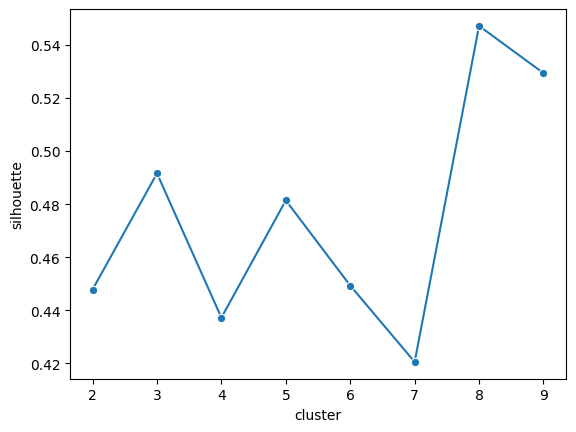

In [586]:
# создадим пустой словарь, ключами будут силуэт и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_gm_silhouette(cluster_num, rfm_tsne))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")  

In [587]:
gm_clustering = GaussianMixture(n_components=7, random_state=42)
# обучаем модель 
gm_clustering.fit(rfm_tsne)
# для матрицы X получаем предсказания к какому кластеру принадлежат объекты
gm_prediction = gm_clustering.predict(rfm_tsne)
print(np.unique(gm_prediction, return_counts=True))
rfm_table['gm_cluster'] = gm_prediction
rfm_table['gm_cluster'].value_counts()

(array([0, 1, 2, 3, 4, 5, 6]), array([ 395,  414, 1194,  310,  902,  318,  511]))


gm_cluster
2    1194
4     902
6     511
1     414
0     395
5     318
3     310
Name: count, dtype: int64

<Axes: xlabel='x', ylabel='y'>

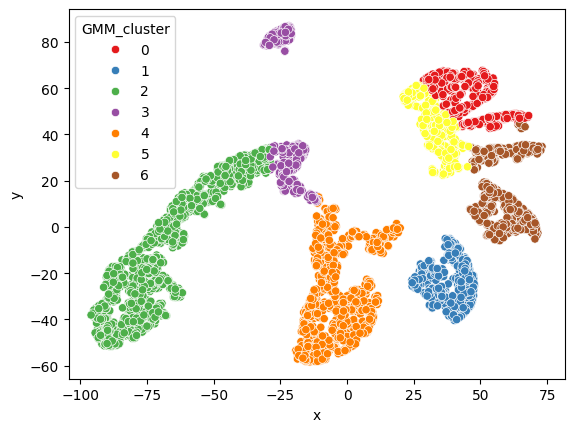

In [588]:
# визуализируем кластеризацию:
fig = plt.Figure(figsize=(15, 8))
rfm_tsne_df['GMM_cluster'] = gm_prediction
sns.scatterplot(data=rfm_tsne_df, hue='GMM_cluster', x='x', y='y', palette='Set1')

In [589]:
rfm_tsne_df

,x,y,Kmeans_cluster,Agglo_cluster,GMM_cluster
0,-18.226166,35.994556,3,4,3
1,29.747231,46.652851,5,2,5
2,51.972454,7.626572,6,0,6
3,11.254126,-33.515232,4,3,4
4,-22.145432,28.751497,3,4,3
...,...,...,...,...,...
4039,-80.313126,-15.632136,2,1,2
4040,-32.523891,30.427839,3,4,2
4041,-61.928261,12.780834,3,4,2
4042,-16.591383,-56.721764,4,3,4


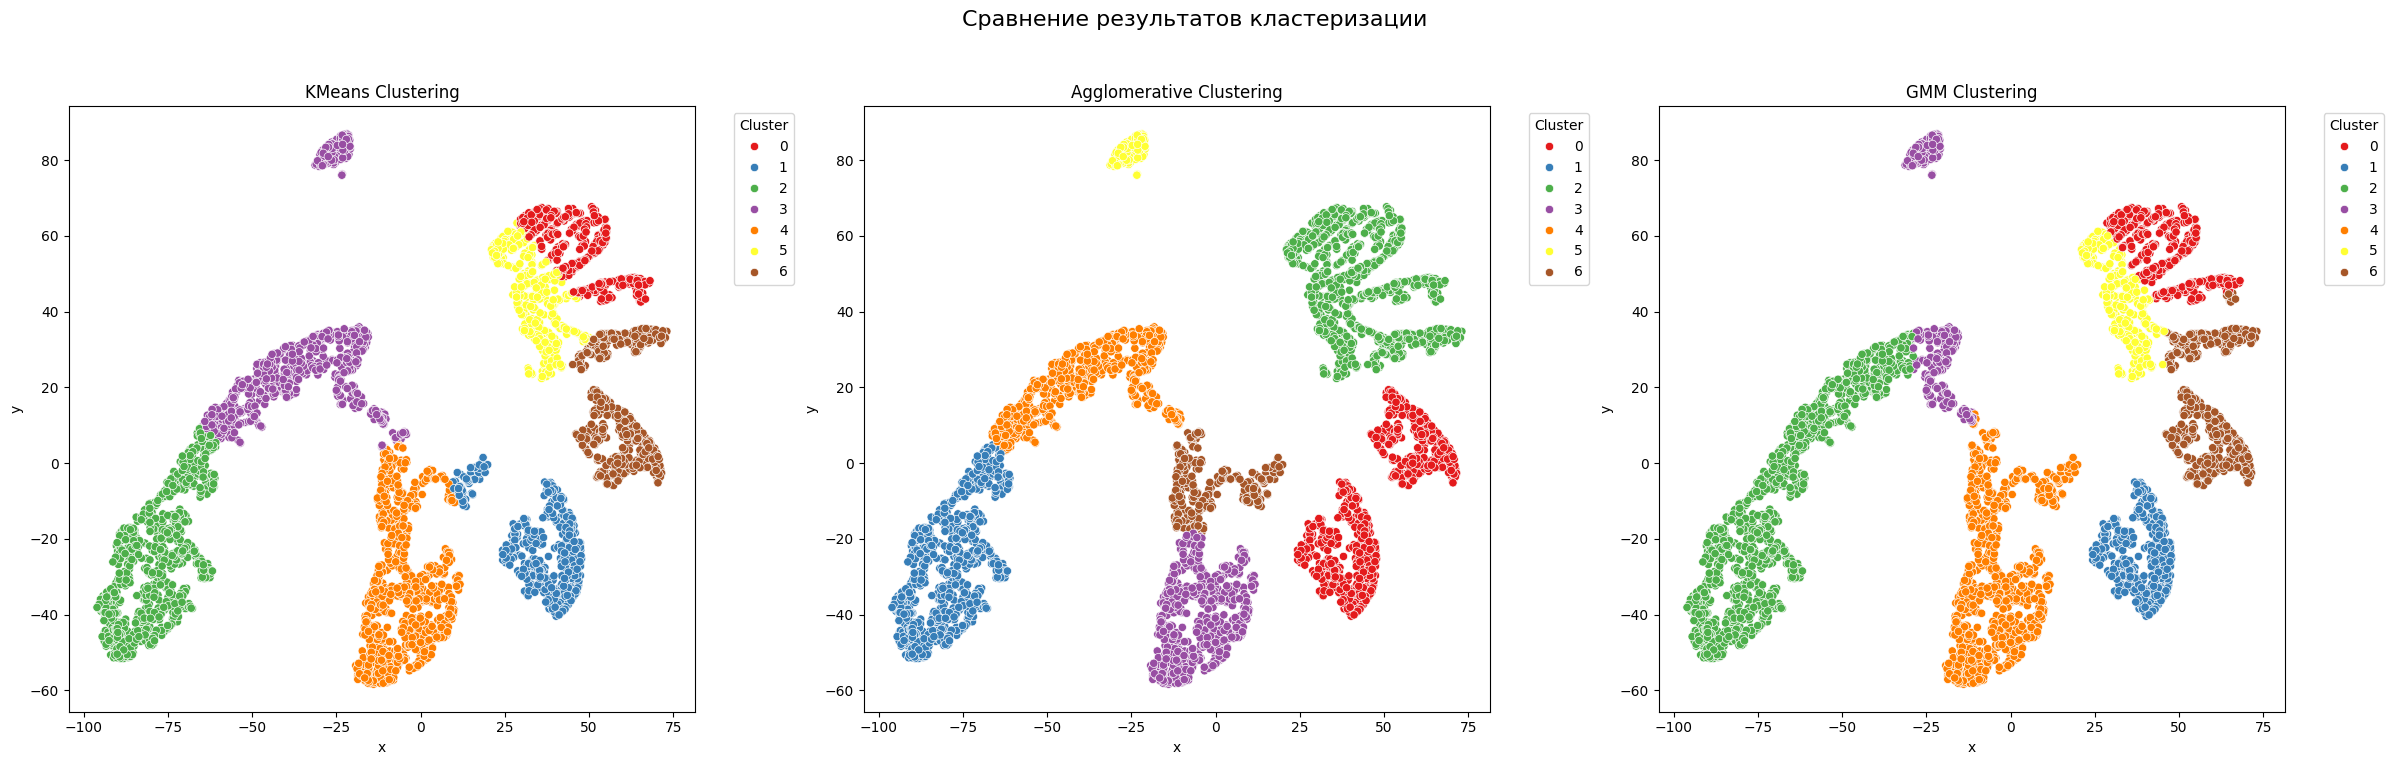

In [590]:
# Создаем сетку подграфиков
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Визуализация для KMeans
sns.scatterplot(
    ax=axes[0],
    data=rfm_tsne_df,
    hue='Kmeans_cluster',
    x='x',
    y='y',
    palette='Set1',
    legend='full'
)
axes[0].set_title('KMeans Clustering')
axes[0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Визуализация для Agglomerative Clustering
sns.scatterplot(
    ax=axes[1],
    data=rfm_tsne_df,
    hue='Agglo_cluster',
    x='x',
    y='y',
    palette='Set1',
    legend='full'
)
axes[1].set_title('Agglomerative Clustering')
axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Визуализация для GMM
sns.scatterplot(
    ax=axes[2],
    data=rfm_tsne_df,
    hue='GMM_cluster',
    x='x',
    y='y',
    palette='Set1',
    legend='full'
)
axes[2].set_title('GMM Clustering')
axes[2].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Настройка общего заголовка
plt.suptitle('Сравнение результатов кластеризации', fontsize=16)

# Настройка отображения
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

Визуализируйте результаты в виде 3D-диаграммы с осями Recency, Frequency и Monetary. Проанализируйте полученную диаграмму и попробуйте понять, какие кластеры у вас получились.

In [591]:
#строим график
fig = px.scatter_3d(
    data_frame=rfm_table, #датафрейм 
    x = 'Recency', #ось абсцисс
    y = 'Frequency', #ось ординат
    z = 'Monetary', #ось аппликат
    color='Kmeans_cluster', #расцветка в зависимости от кластера
    log_x=True, 
    log_y=True,
    width=1000,
    height=700
)
#отображаем его
fig.show()

При таком разделении, кластеры 6,3,7 находятся очень близко и они малочисленны

#### 3.2.2. Построение профиля кластеров

Далее составьте так называемый профиль кластеров. Для этого вам необходимо вернуться от декомпозированных данных (если вы производили понижение размерности) к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать, давайте познакомимся с одним из способов визуализации профиля кластеров — **Radar Chart** (полярная диаграмма, или диаграмма паутины). Это графическое представление значений нескольких эквивалентных категорий в форме паутины.

Radar Chart часто используется при определении профиля кластеров. На концах паутины откладываются оси, соответствующие признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 

Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На этой диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие этому кластеру, в большей степени увлекаются музыкой (Music), а в меньшей — программированием (Programm).

В модуле `graph_objects` библиотеки `plotly` есть встроенная функция `Scatterpolar`, которая позволяет построить полярную диаграмму. На основе этой функции мы подготовили для вас функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У неё есть два параметра: `grouped_data` — сгруппированные по кластерам характеристики объектов (клиентов), `n_clusters` — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в функцию `plot_cluster_profile()`.


In [592]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

Теперь у вас есть удобный инструмент для анализа профиля кластеров. Воспользуйтесь им, чтобы проинтерпретировать результаты, полученные на предыдущем шаге.

In [593]:
grouped_rfm = rfm_table.groupby('Kmeans_cluster').mean()
grouped_rfm = grouped_rfm.drop(['Agglo_cluster',
                                'gm_cluster'],axis=1)
grouped_rfm


,Recency,Frequency,Monetary
Kmeans_cluster,,,
0,25.855228,7.836461,1835.128123
1,64.220374,3.081081,899.223555
2,62.418317,1.000000,316.827475
3,275.858136,1.126565,315.439430
4,88.977833,2.006158,613.214803
5,38.714286,6.574176,3485.989011
6,38.149897,4.367556,1189.613634


In [594]:
plot_cluster_profile(grouped_rfm, 7)

In [595]:
rfm_table = rfm_table.drop(['DBSCAN_cluster','Agglo_cluster','gm_cluster'],axis=1)


KeyError: "['DBSCAN_cluster'] not found in axis"

In [284]:
grouped_freuancy = rfm_table.groupby('Kmeans_cluster')['Frequency']
grouped_freuancy.describe()

,count,mean,std,min,25%,50%,75%,max
Kmeans_cluster,,,,,,,,
0,469.0,8.573561,2.107532,3.0,7.0,8.0,10.0,13.0
1,779.0,1.970475,0.169382,1.0,2.0,2.0,2.0,2.0
2,775.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
3,658.0,1.168693,0.584262,1.0,1.0,1.0,1.0,6.0
4,466.0,3.791845,0.657151,1.0,4.0,4.0,4.0,6.0
5,346.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
6,437.0,4.915332,1.072880,1.0,5.0,5.0,6.0,7.0
7,114.0,1.043860,0.205687,1.0,1.0,1.0,1.0,2.0


## 5. Выводы и оформление работы

Напишите заключение о проделанной работе и полученных результатах. Отметьте, какие сегменты клиентов вам удалось найти в данных.

После завершения проекта создайте в своём репозитории файл README.md и кратко опишите содержимое проекта по принципу, который мы приводили ранее.

Выложите свой проект на GitHub и оформите удалённый репозиторий, добавив в него описание и теги репозитория (теги придумайте самостоятельно в зависимости от того, какую задачу вы решали).